In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerBase
import matplotlib.patches as mpatches

from pathlib import Path
from IPython.display import display

from config import DATA_DIR, OUTPUT_DIR

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

In [37]:
monthly_doses_andexanet = pd.read_csv("../data/monthly_doses_andexanet.csv",  index_col=0, parse_dates=True)

total_doses_andexanet = monthly_doses_andexanet[["Doses"]].sum().astype(int)
total_doses_andexanet.name = "Total"
total_doses_andexanet.index.name = "Unit"
total_doses_andexanet = total_doses_andexanet.map('{:,}'.format)
total_doses_andexanet.to_csv(Path(OUTPUT_DIR, "total_doses_andexanet.csv"))
display(total_doses_andexanet)

Unit
Doses    19,608
Name: Total, dtype: object

In [ ]:
all_ods_codes = pd.read_csv(Path(DATA_DIR, "all_ods_codes.csv"))
andexanet_df = pd.read_csv(Path(DATA_DIR, "monthly_doses_andexanet_by_trust.csv"), parse_dates=["Date"], dtype={"Value": float})
measure = pd.read_csv("../data/monthly_measure_by_trust.csv", parse_dates=["Date"])

In [23]:
trusts_used_aa = andexanet_df.groupby("Trust Code")["Value"].apply(lambda x: (x > 0).any())

In [24]:
all_ods_codes["used_aa"] = all_ods_codes["ods_code"].isin(trusts_used_aa.index)
all_ods_codes.sort_values(["has_ae_last_six_months", "used_aa", "ods_name"])
all_ods_codes.to_csv("../output/has_ae_used_aa.csv", index=False)

print(f"Trusts with A&E: {all_ods_codes[all_ods_codes["has_ae_last_six_months"]==True]["has_ae_last_six_months"].sum()}")

print(f"Trusts used AA: {all_ods_codes[all_ods_codes["used_aa"]==True]["used_aa"].sum()}")




Trusts with A&E: 121
Trusts used AA: 117


In [25]:
def setup_plot(ax, ylabel):
    ax.set_ylabel(ylabel, fontsize=28)
    ax.tick_params(axis='both', labelsize=22, length=10, width=2)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.margins(x=0)
    ax.grid(True, linestyle='-', linewidth=2)

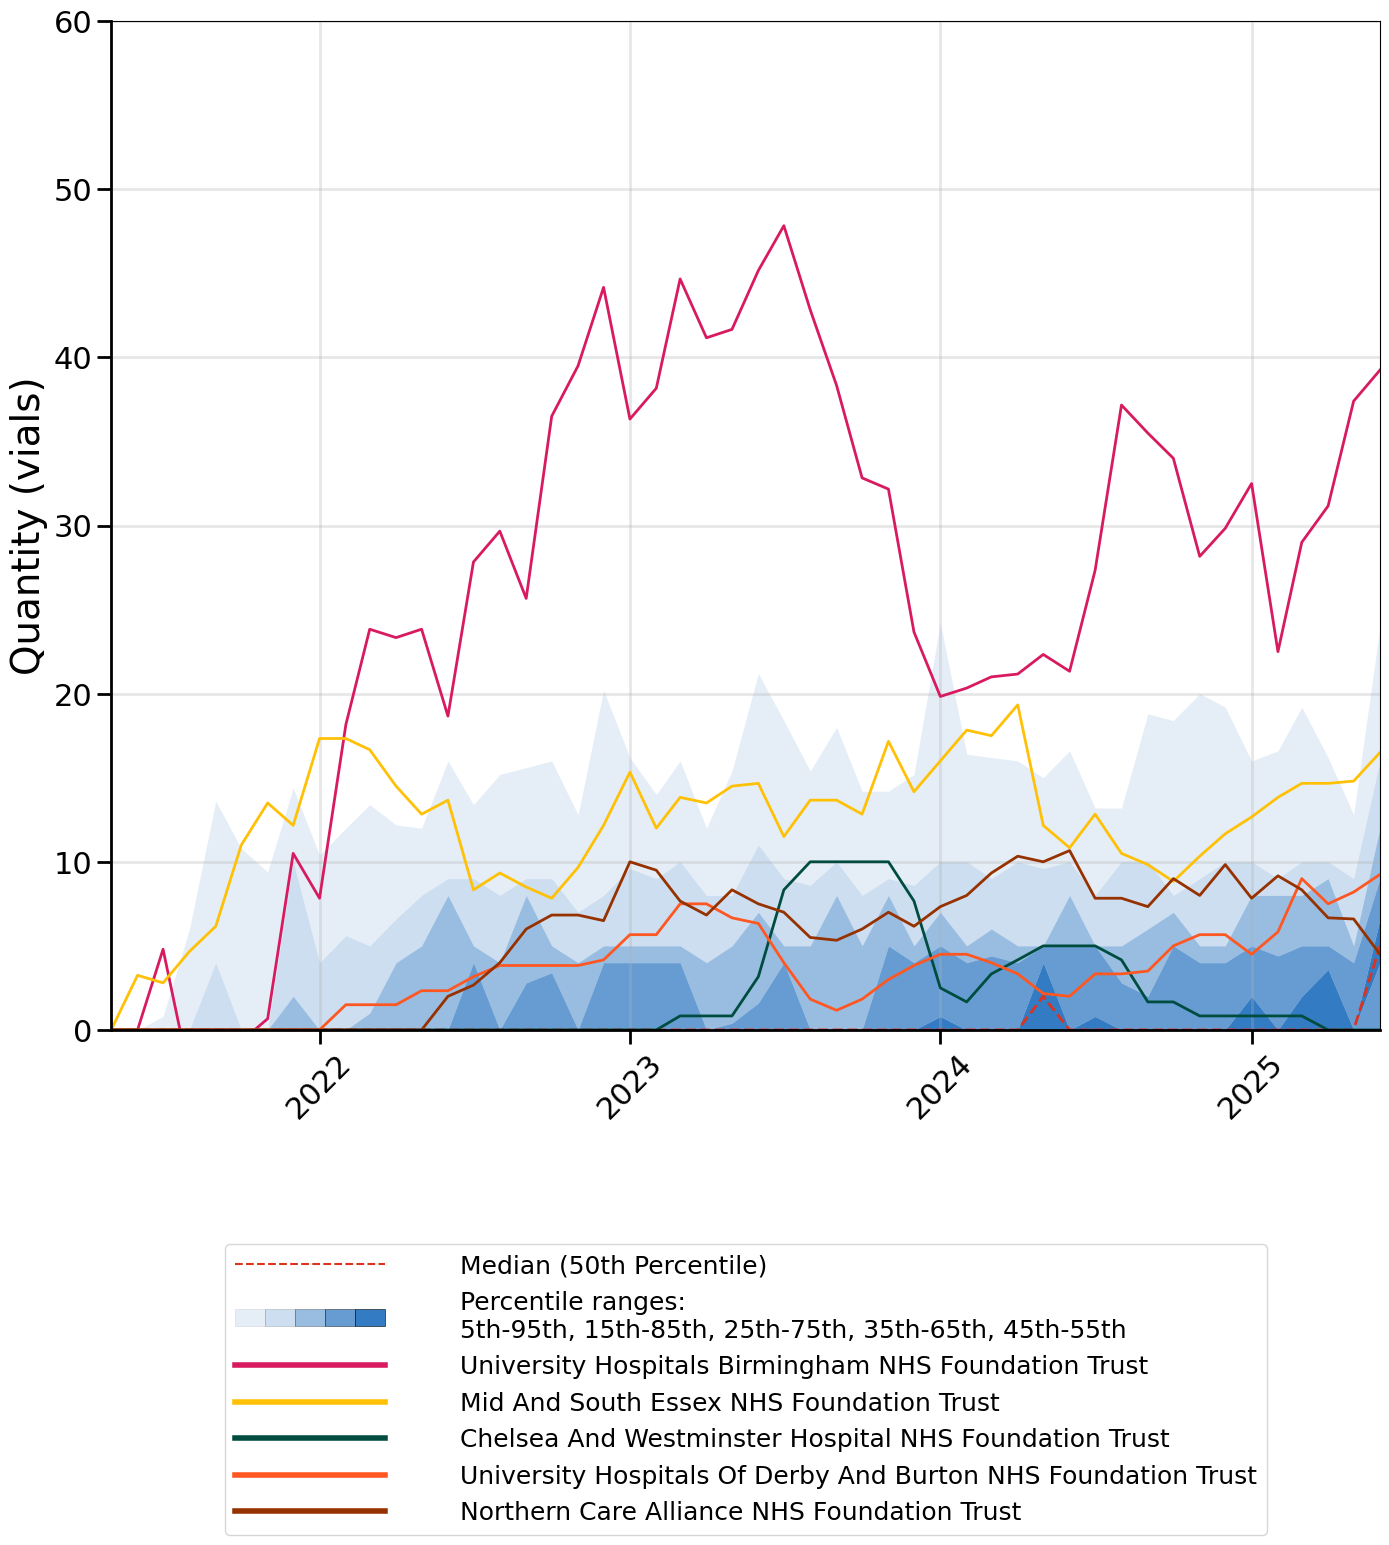

In [26]:
class MultiPatchHandler(HandlerBase):
    """Custom legend handler for multiple patches in a single legend entry"""
    def __init__(self, patches):
        self.patches = patches
        super().__init__()
    
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create 5 small patches side by side
        patch_width = width / 5
        artists = []
        
        for i, (alpha, label) in enumerate(self.patches):
            patch = mpatches.Rectangle(
                (xdescent + i * patch_width, ydescent), 
                patch_width, 
                height,
                facecolor="#005AB5", 
                alpha=alpha,
                edgecolor="black",  # Black outline
                linewidth=0.5,  
                transform=trans
            )
            artists.append(patch)
        
        return artists

def plot_deciles(
    data, output_file_name, ylim=100, ylab="", overlay_orgs=None, org_colors=None
):
    """
    Creates a deciles chart showing distribution of values across organizations over time
    Args:
        data: DataFrame containing the data
        output_file_name: Name of output file
        ylim: Y-axis limit
        ylab: Y-axis label
        overlay_orgs: List of ods_codes to overlay on the plot
        org_colors: Dictionary mapping ods_codes to colors for the overlay lines
    """

    def get_monthly_percentiles(df):

        monthly_stats = df.pivot_table(
            index="Date",
            columns="Trust Code",
            values="Value",
            aggfunc="sum",
            fill_value=0,
        )

        percentiles = pd.DataFrame(index=monthly_stats.index)
        percentiles["p05"] = monthly_stats.apply(lambda x: np.percentile(x, 5), axis=1)
        percentiles["p15"] = monthly_stats.apply(lambda x: np.percentile(x, 15), axis=1)
        percentiles["p25"] = monthly_stats.apply(lambda x: np.percentile(x, 25), axis=1)
        percentiles["p35"] = monthly_stats.apply(lambda x: np.percentile(x, 35), axis=1)
        percentiles["p45"] = monthly_stats.apply(lambda x: np.percentile(x, 45), axis=1)
        percentiles["p50"] = monthly_stats.apply(lambda x: np.percentile(x, 50), axis=1)
        percentiles["p55"] = monthly_stats.apply(lambda x: np.percentile(x, 55), axis=1)
        percentiles["p65"] = monthly_stats.apply(lambda x: np.percentile(x, 65), axis=1)
        percentiles["p75"] = monthly_stats.apply(lambda x: np.percentile(x, 75), axis=1)
        percentiles["p85"] = monthly_stats.apply(lambda x: np.percentile(x, 85), axis=1)
        percentiles["p95"] = monthly_stats.apply(lambda x: np.percentile(x, 95), axis=1)

        return percentiles, monthly_stats

    percentiles, monthly_stats = get_monthly_percentiles(data)

    fig, ax = plt.subplots(figsize=(14, 16))
    setup_plot(ax, ylab)

    ax.fill_between(
        percentiles.index,
        percentiles["p05"],
        percentiles["p15"],
        alpha=0.1,
        color="#005AB5",
        linewidth=0
    )
    ax.fill_between(
        percentiles.index,
        percentiles["p85"],
        percentiles["p95"],
        alpha=0.1,
        color="#005AB5",
        linewidth=0
    )

    ax.fill_between(
        percentiles.index,
        percentiles["p15"],
        percentiles["p25"],
        alpha=0.2,
        color="#005AB5",
        linewidth=0
    )
    ax.fill_between(
        percentiles.index,
        percentiles["p75"],
        percentiles["p85"],
        alpha=0.2,
        color="#005AB5",
        linewidth=0
    )

    ax.fill_between(
        percentiles.index,
        percentiles["p25"],
        percentiles["p35"],
        alpha=0.4,
        color="#005AB5",
        linewidth=0
    )
    ax.fill_between(
        percentiles.index,
        percentiles["p65"],
        percentiles["p75"],
        alpha=0.4,
        color="#005AB5",
        linewidth=0
    )

    ax.fill_between(
        percentiles.index,
        percentiles["p35"],
        percentiles["p45"],
        alpha=0.6,
        color="#005AB5",
        linewidth=0
    )
    ax.fill_between(
        percentiles.index,
        percentiles["p55"],
        percentiles["p65"],
        alpha=0.6,
        color="#005AB5",
        linewidth=0
    )

    ax.fill_between(
        percentiles.index,
        percentiles["p45"],
        percentiles["p55"],
        alpha=0.8,
        color="#005AB5",
        linewidth=0
    )

    ax.plot(
        percentiles.index,
        percentiles["p50"],
        color="#DC3220",
        linestyle="--",
        linewidth=2,
    )

    legend_elements = []

    legend_elements.append(
        Line2D(
            [0],
            [0],
            color="#DC3220",
            linestyle="--",
            label="Median (50th Percentile)",
        )
    )

    percentile_patches = [
        (0.1, "5th-95th"),
        (0.2, "15th-85th"), 
        (0.4, "25th-75th"),
        (0.6, "35th-65th"),
        (0.8, "45th-55th")
    ]

    percentile_legend_patch = Patch(facecolor="#005AB5", alpha=0.5, label="Percentile ranges:\n5th-95th, 15th-85th, 25th-75th, 35th-65th, 45th-55th")
    legend_elements.append(percentile_legend_patch)

    org_names = (
        data[["Trust Code", "Trust Name"]]
        .drop_duplicates()
        .set_index("Trust Code")["Trust Name"]
    )

    if overlay_orgs:
        for org in overlay_orgs:
            if org in monthly_stats.columns:
                color = org_colors.get(
                    org, "black"
                )

                rolling_avg = (
                     monthly_stats[org].rolling(window=6, center=True, min_periods=1).mean()
                )

                ax.plot(
                    rolling_avg.index,
                    rolling_avg,
                    color=color,
                    linewidth=2,
                    label=org_names[org],
                )
                legend_elements.append(Line2D([0], [0], color=color, label=org_names[org], linewidth=4))

    ax.set_ylim(0, ylim)
    ax.set_ylabel(ylab)
    ax.tick_params(axis="x", rotation=45)

    legend = ax.legend(
        handles=legend_elements, 
        loc="upper center", 
        bbox_to_anchor=(0.5, -0.2), 
        ncol=1,
        fontsize=18,
        columnspacing=1,
        handlelength=6,
        handletextpad=3,
        handler_map={percentile_legend_patch: MultiPatchHandler(percentile_patches)}
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR, output_file_name), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


# RRK = Birmingham
# RAJ = mid and south essex
# RQM = 
# RTG = 
# RM3 - 

overlay_orgs = ["RRK","RAJ", "RQM", "RTG", "RM3"]
org_colors = {
    "RRK": "#D81B60",  
    "RAJ": "#FFC107",
    "RQM": "#004D40",
    "RTG": "#FF5722",
    "RM3": "#963100" 
}

plot_deciles(
    data=andexanet_df,
    output_file_name="deciles_andexanet.png",
    ylim=60,
    ylab="Quantity (vials)",
    overlay_orgs=overlay_orgs,
    org_colors=org_colors,
)

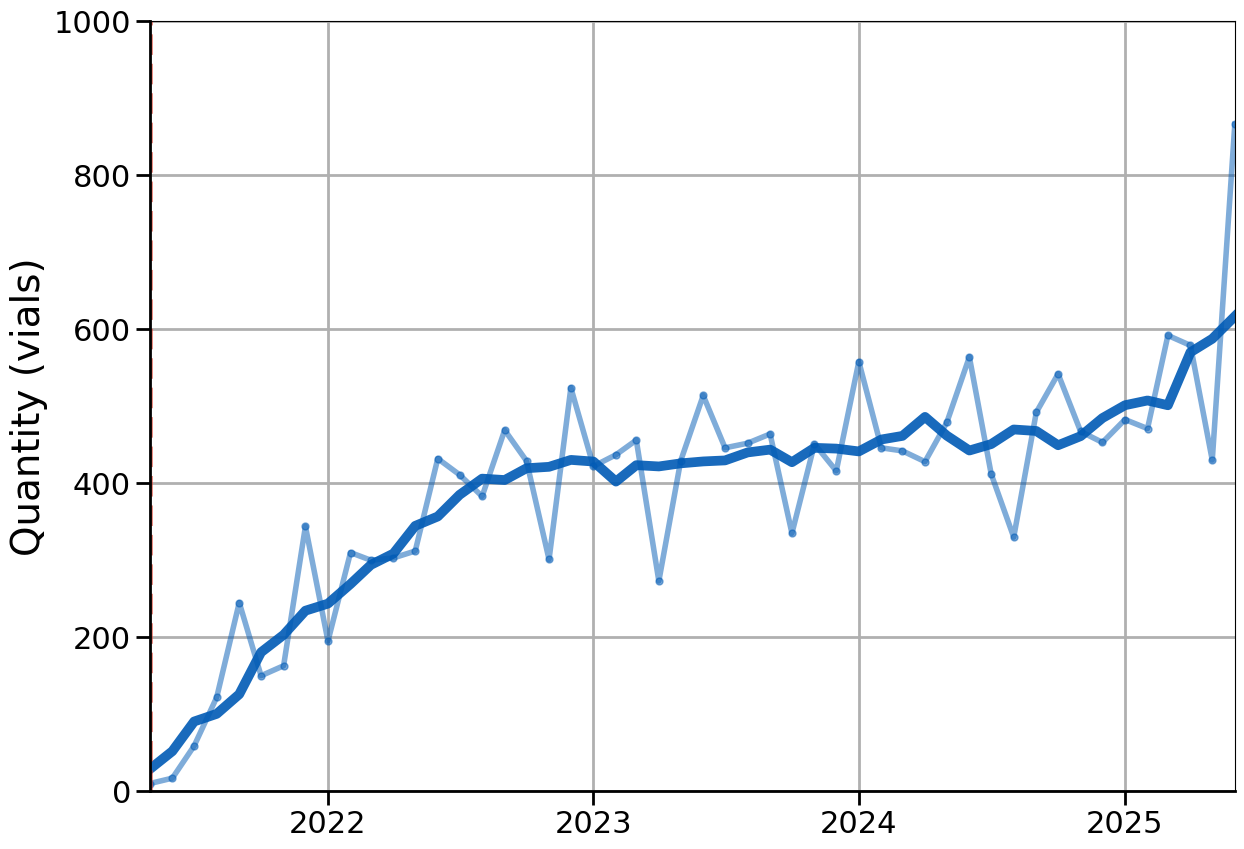

In [27]:
def smooth_and_plot(data, output_file_name, ylim=100, ylab=""):
    rolling_avg = data.rolling(window=6, center=True, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.plot(data.index, data, linewidth=4, alpha=0.5, color='#005AB5', marker='.', markersize=10)
    ax.plot(rolling_avg.index, rolling_avg, linewidth=7, alpha=0.9, color='#005AB5')  # Plot rolling average
    ax.vlines(x=pd.to_datetime('2021-05-01'), ymin=0, ymax=ylim, color='#DC3220', linestyle='--', linewidth=4, alpha=0.7)
    setup_plot(ax, ylab)
    plt.ylim(0, ylim)
    plt.savefig(Path(OUTPUT_DIR, output_file_name), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
        
smooth_and_plot(monthly_doses_andexanet, "monthly_doses_andexanet.png", ylim=1000, ylab="Quantity (vials)")

In [28]:
andexanet_post_may_21 = andexanet_df[andexanet_df["Date"] > "2021-05-01"]
total_orgs_andexanet_post_may_21 = andexanet_post_may_21[["Trust Code"]].nunique().astype(int)
total_orgs_andexanet_all_time = andexanet_df[["Trust Code"]].nunique().astype(int)   
total_orgs_andexanet = pd.concat([total_orgs_andexanet_post_may_21, total_orgs_andexanet_all_time], axis=1)
total_orgs_andexanet.columns = ["Post May 2021", "All time"]
total_orgs_andexanet.index = ["Total"]
total_orgs_andexanet.to_csv(Path(OUTPUT_DIR, "total_orgs_andexanet.csv"))
display(total_orgs_andexanet)

,Post May 2021,All time
Total,117,117


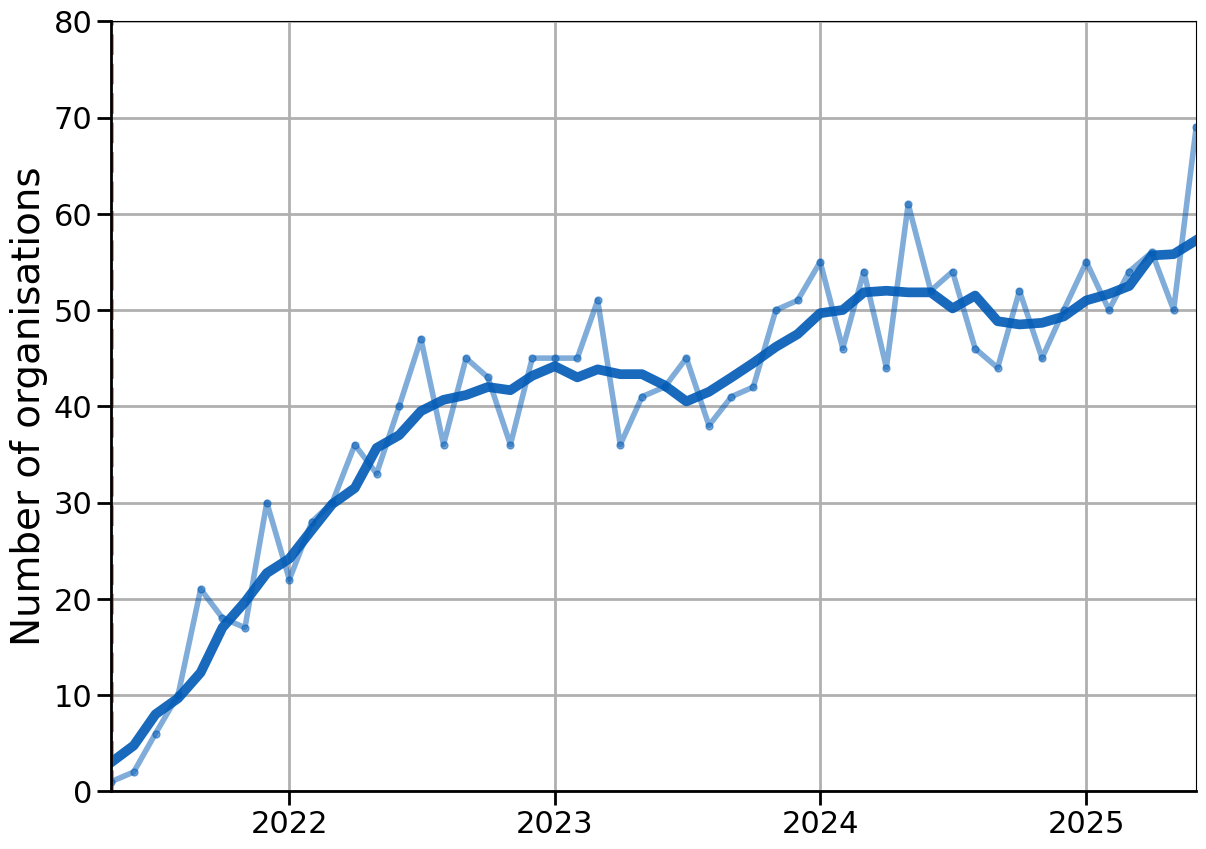

In [29]:
orgs_using_andexanet_monthly = pd.read_csv("../data/orgs_using_andexanet_monthly.csv", index_col=0, parse_dates=True)
smooth_and_plot(orgs_using_andexanet_monthly, "orgs_using_andexanet_monthly.png", ylim=80, ylab="Number of organisations")

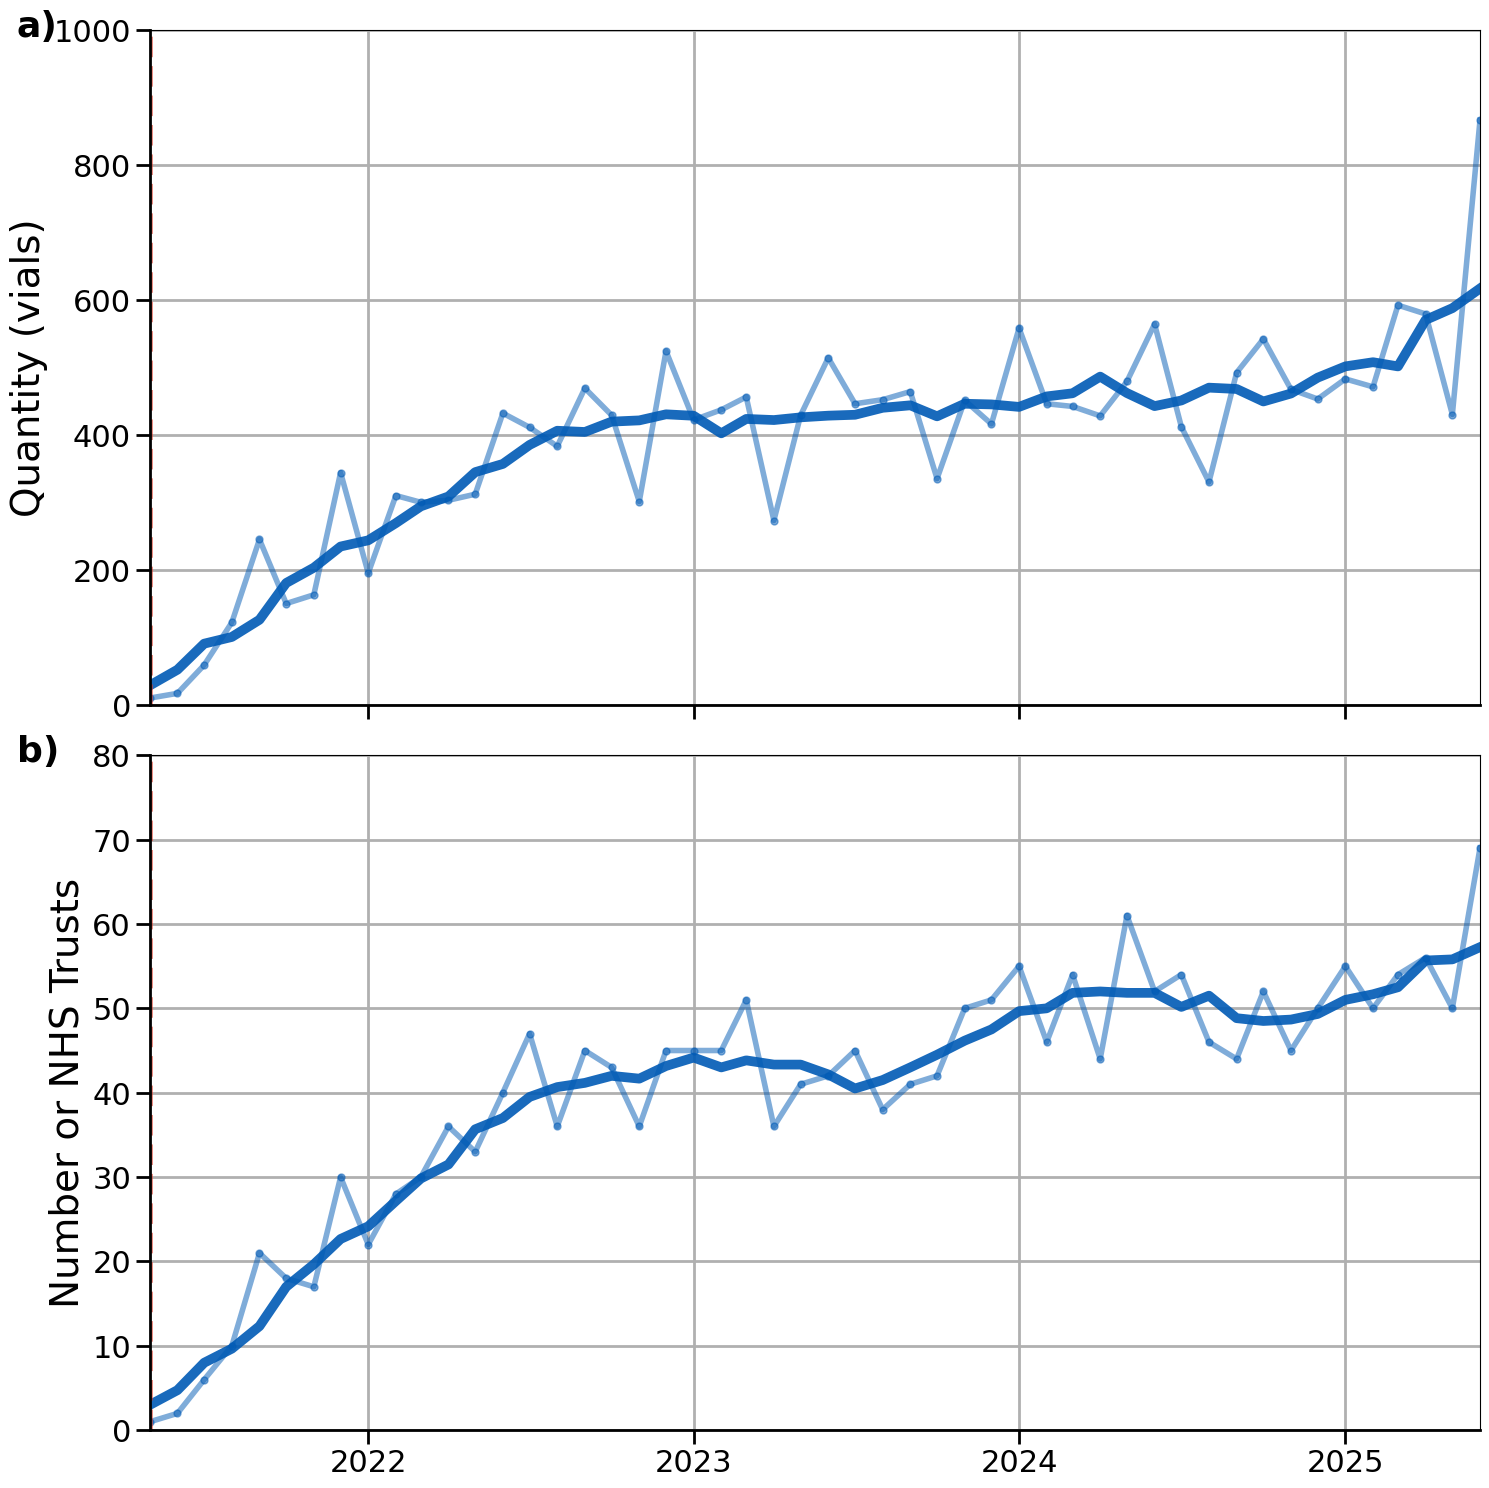

In [30]:

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

rolling_avg = monthly_doses_andexanet.rolling(window=6, center=True, min_periods=1).mean()
axes[0].plot(monthly_doses_andexanet.index, monthly_doses_andexanet, linewidth=4, alpha=0.5, color='#005AB5', marker='.', markersize=10)
axes[0].plot(rolling_avg.index, rolling_avg, linewidth=7, alpha=0.9, color='#005AB5')
axes[0].vlines(x=pd.to_datetime('2021-05-01'), ymin=0, ymax=1000, color='#DC3220', linestyle='--', linewidth=4, alpha=0.7)
setup_plot(axes[0], "Quantity (vials)")
axes[0].set_ylim(0, 1000)
axes[0].set_xticklabels([])

rolling_avg = orgs_using_andexanet_monthly.rolling(window=6, center=True, min_periods=1).mean()
axes[1].plot(orgs_using_andexanet_monthly.index, orgs_using_andexanet_monthly, linewidth=4, alpha=0.5, color='#005AB5', marker='.', markersize=10)
axes[1].plot(rolling_avg.index, rolling_avg, linewidth=7, alpha=0.9, color='#005AB5')
axes[1].vlines(x=pd.to_datetime('2021-05-01'), ymin=0, ymax=80, color='#DC3220', linestyle='--', linewidth=4, alpha=0.7)
setup_plot(axes[1], "Number or NHS Trusts")
axes[1].set_ylim(0, 80)
axes[0].text(-0.1, 0.99, "a)", transform=axes[0].transAxes, fontsize=26, fontweight='bold')
axes[1].text(-0.1, 0.99, "b)", transform=axes[1].transAxes, fontsize=26, fontweight='bold')


plt.tight_layout(h_pad=0.8)
plt.savefig(Path(OUTPUT_DIR, "monthly_usage_and_orgs.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [31]:
monthly_doses_andexanet_by_region = pd.read_csv(Path(DATA_DIR, "monthly_doses_andexanet_by_region.csv"), index_col=0, parse_dates=True)

In [32]:
def plot_regional_volumes(df, output_file_name, ylim=100, ylab=""):
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
    axes = axes.flatten()

    regions_ordered = [
        "North West",
        "North East And Yorkshire", 
        "Midlands",
        "East Of England",
        "South West",
        "London",
        "South East"
    ]
    for idx, main_region in enumerate(regions_ordered):
        plot_single_region(axes[idx], df, main_region, ylim)

    fig.text(0.02, 0.5, ylab, va='center', rotation='vertical', fontsize=32)

    for idx in range(len(regions_ordered), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.savefig(Path(OUTPUT_DIR, output_file_name), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_single_region(ax, single_volumes_by_region, main_region, ylim=100):
    for region in single_volumes_by_region.columns:
        if region != main_region:
            region_data = single_volumes_by_region[region]
            rolling_avg = region_data.rolling(window=6, center=True, min_periods=1).mean()
            ax.plot(rolling_avg.index, rolling_avg, color='grey', linewidth=3, alpha=0.3)

    main_region_data = single_volumes_by_region[main_region]
    rolling_avg = main_region_data.rolling(window=6, center=True, min_periods=1).mean()
    ax.plot(rolling_avg.index, rolling_avg, color='#005AB5', linewidth=5, alpha=0.9)
    ax.plot(main_region_data.index, main_region_data, color='#005AB5', linewidth=3, alpha=0.5, marker='.', markersize=10)
    ax.vlines(x=pd.to_datetime('2021-05-01'), ymin=0, ymax=ylim, color='#DC3220', linestyle='--', linewidth=3, alpha=0.7)

    ax.set_title(main_region, fontsize=26)
    setup_plot(ax, '')
    ax.set_ylim(0, ylim)

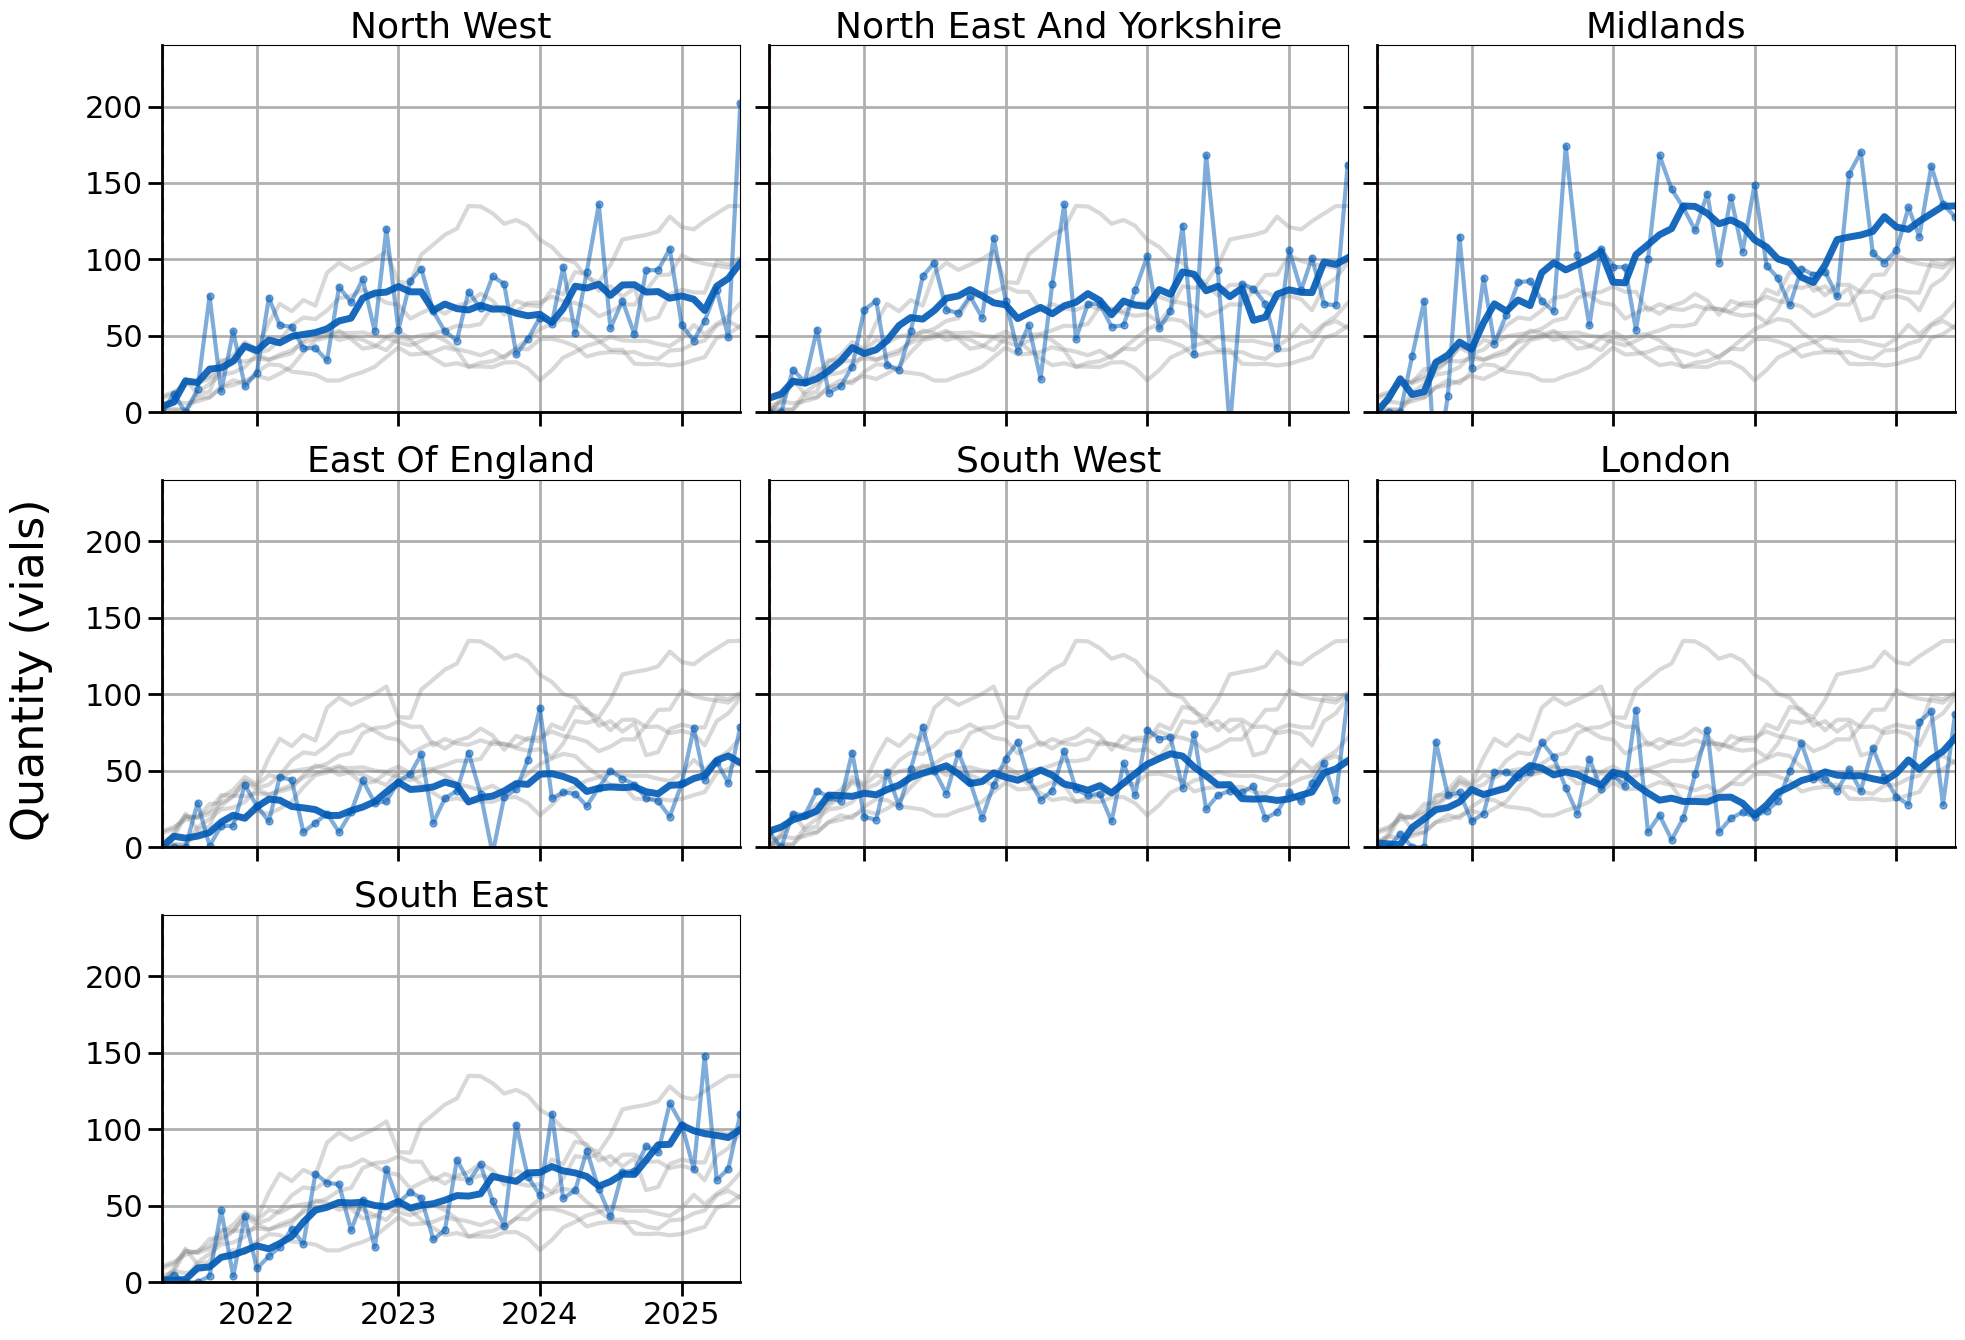

In [33]:
plot_regional_volumes(monthly_doses_andexanet_by_region, "monthly_doses_andexanet_by_region.png", ylim=240, ylab="Quantity (vials)")

In [34]:
def plot_regional_volumes_combined(df, output_file_name, ylim=100, ylab=""):
    fig, ax = plt.subplots(figsize=(20, 12))

    regions_ordered = [
        "North West",
        "North East And Yorkshire", 
        "Midlands",
        "East Of England",
        "South West",
        "London",
        "South East"
    ]

    colors = plt.cm.tab10(np.linspace(0, 1, len(regions_ordered)))

    for idx, region in enumerate(regions_ordered):
        region_data = df[region]
        rolling_avg = region_data.rolling(window=6, center=True, min_periods=1).mean()
        ax.plot(rolling_avg.index, rolling_avg, color=colors[idx], linewidth=5, label=region)

    ax.vlines(x=pd.to_datetime('2021-05-01'), ymin=0, ymax=ylim, color='#DC3220', linestyle='--', linewidth=3, alpha=0.7)
    setup_plot(ax, ylab)
    ax.set_ylim(0, ylim)
    ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR, output_file_name), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


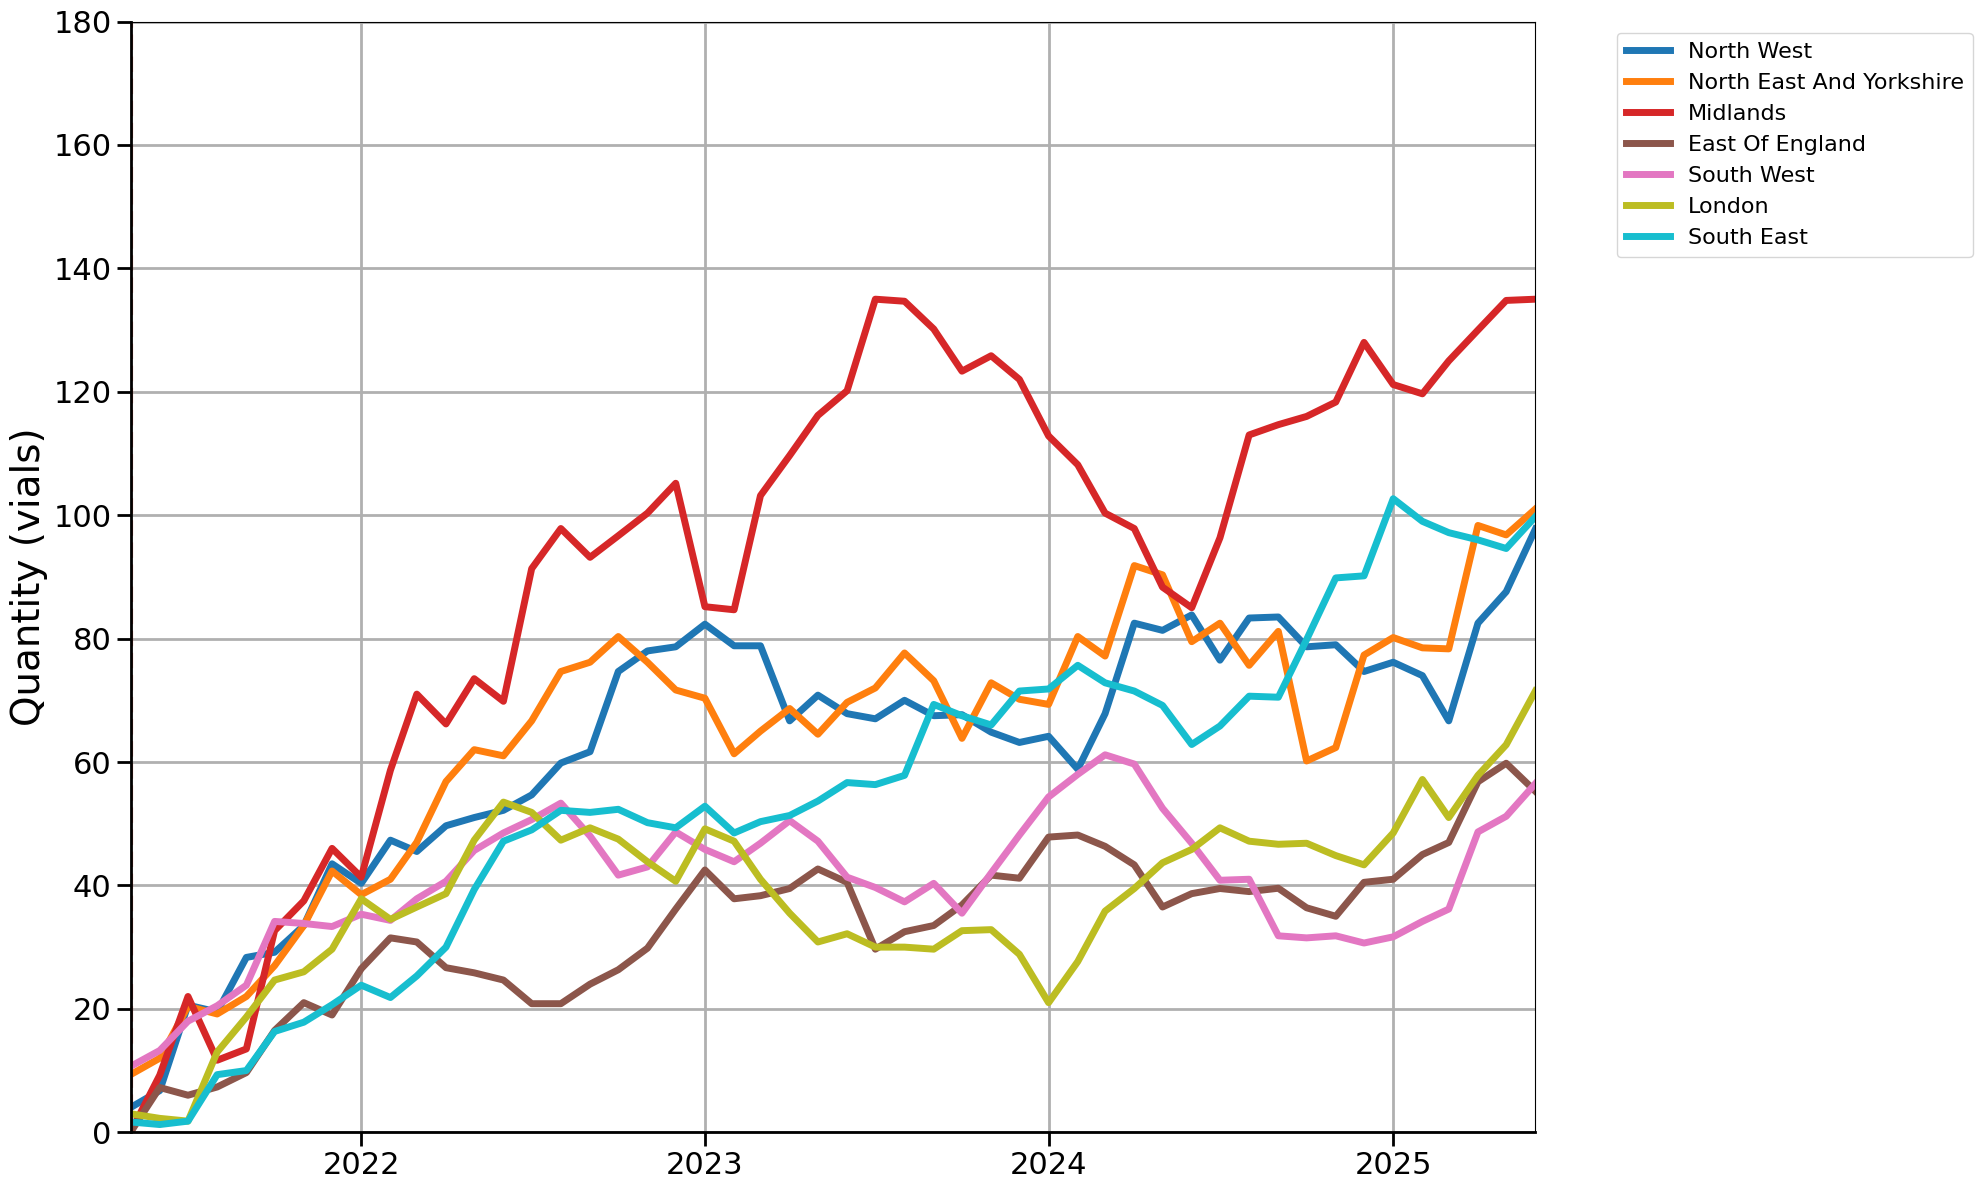

In [35]:
plot_regional_volumes_combined(monthly_doses_andexanet_by_region, "monthly_doses_andexanet_by_region_grouped.png", ylim=180, ylab="Quantity (vials)")

In [48]:
measure_by_region = pd.read_csv(Path(DATA_DIR, "measure_by_region.csv"), index_col=0, parse_dates=True)

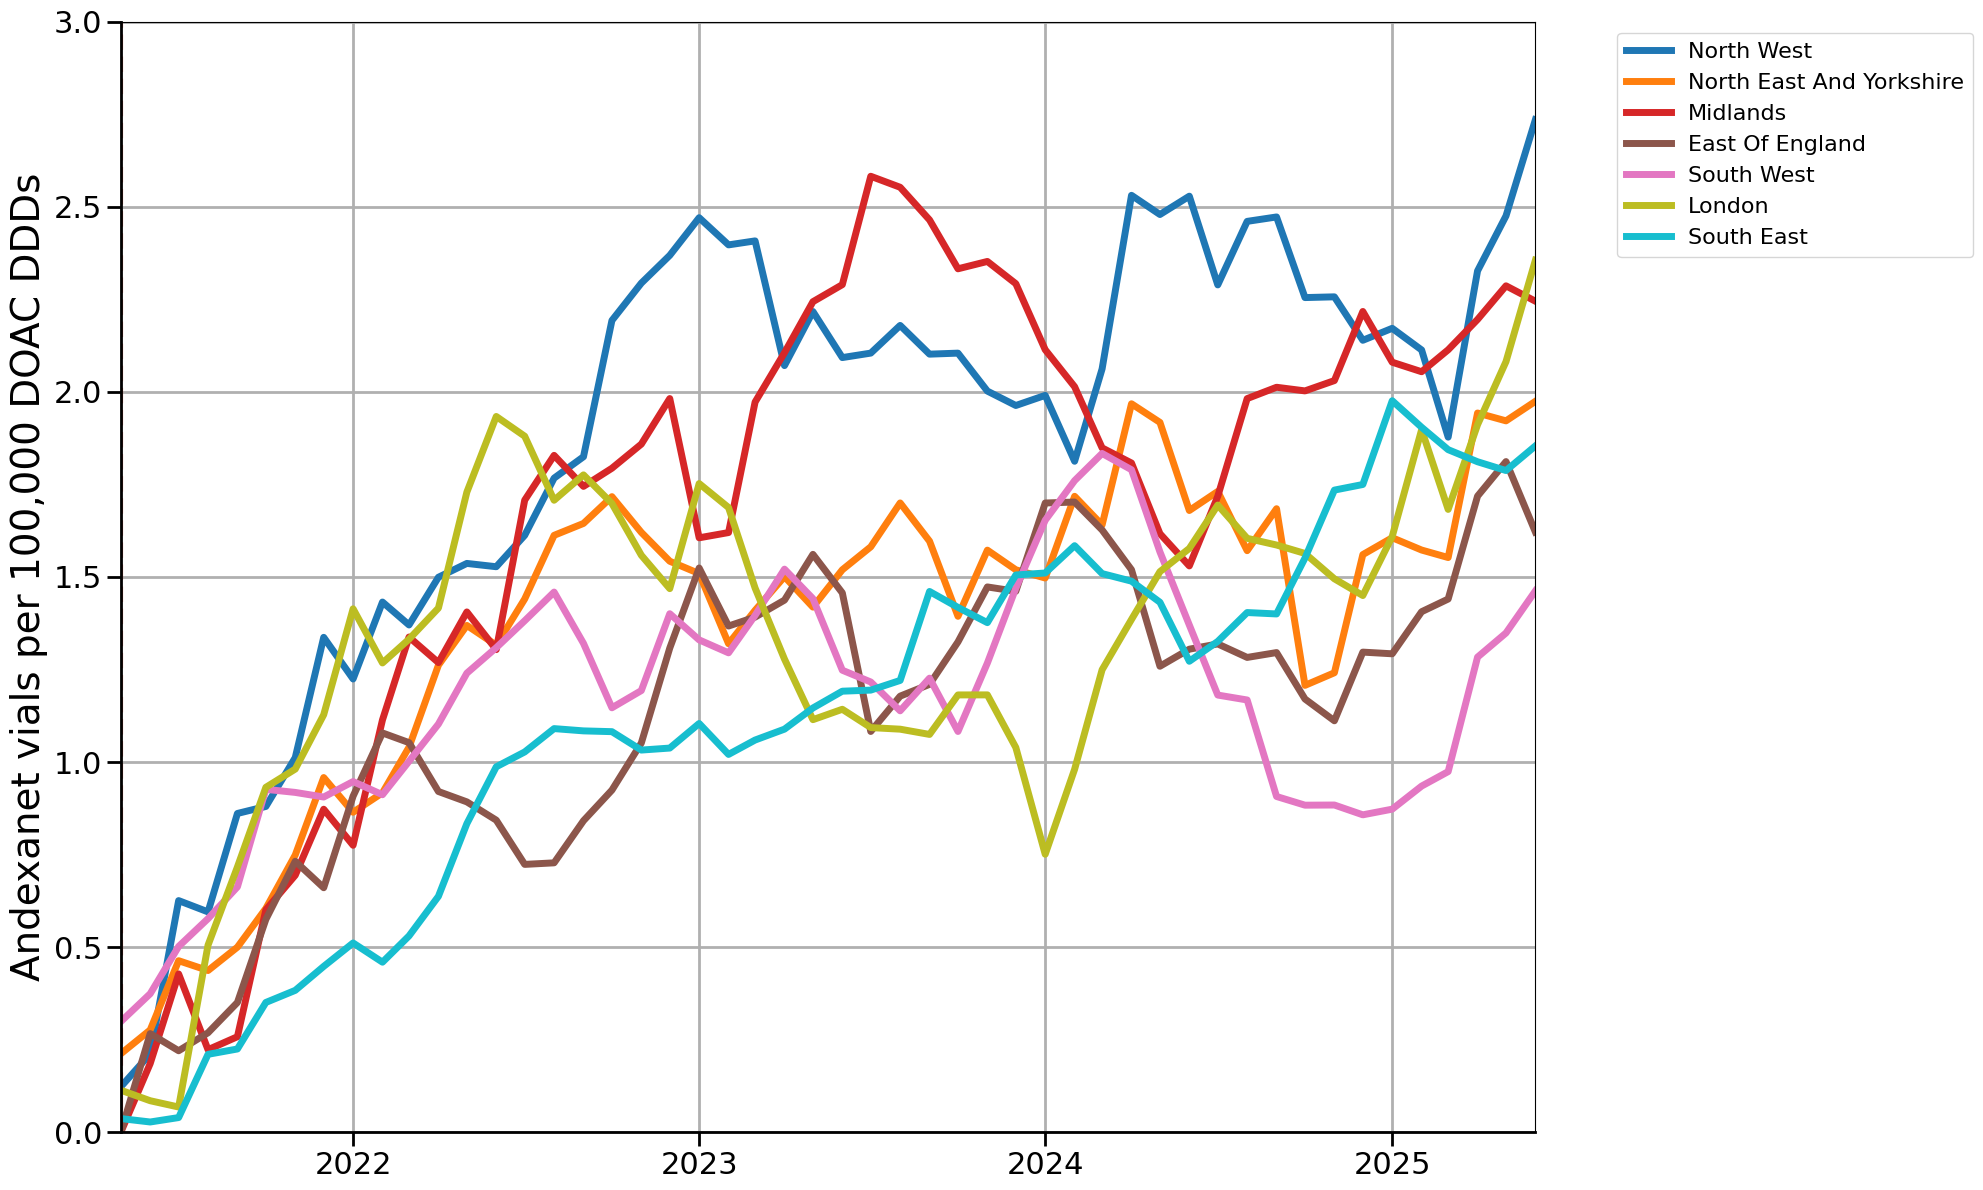

In [52]:
plot_regional_volumes_combined(measure_by_region, "measure_by_region_grouped.png", ylim=3, ylab="Andexanet vials per 100,000 DOAC DDDs")

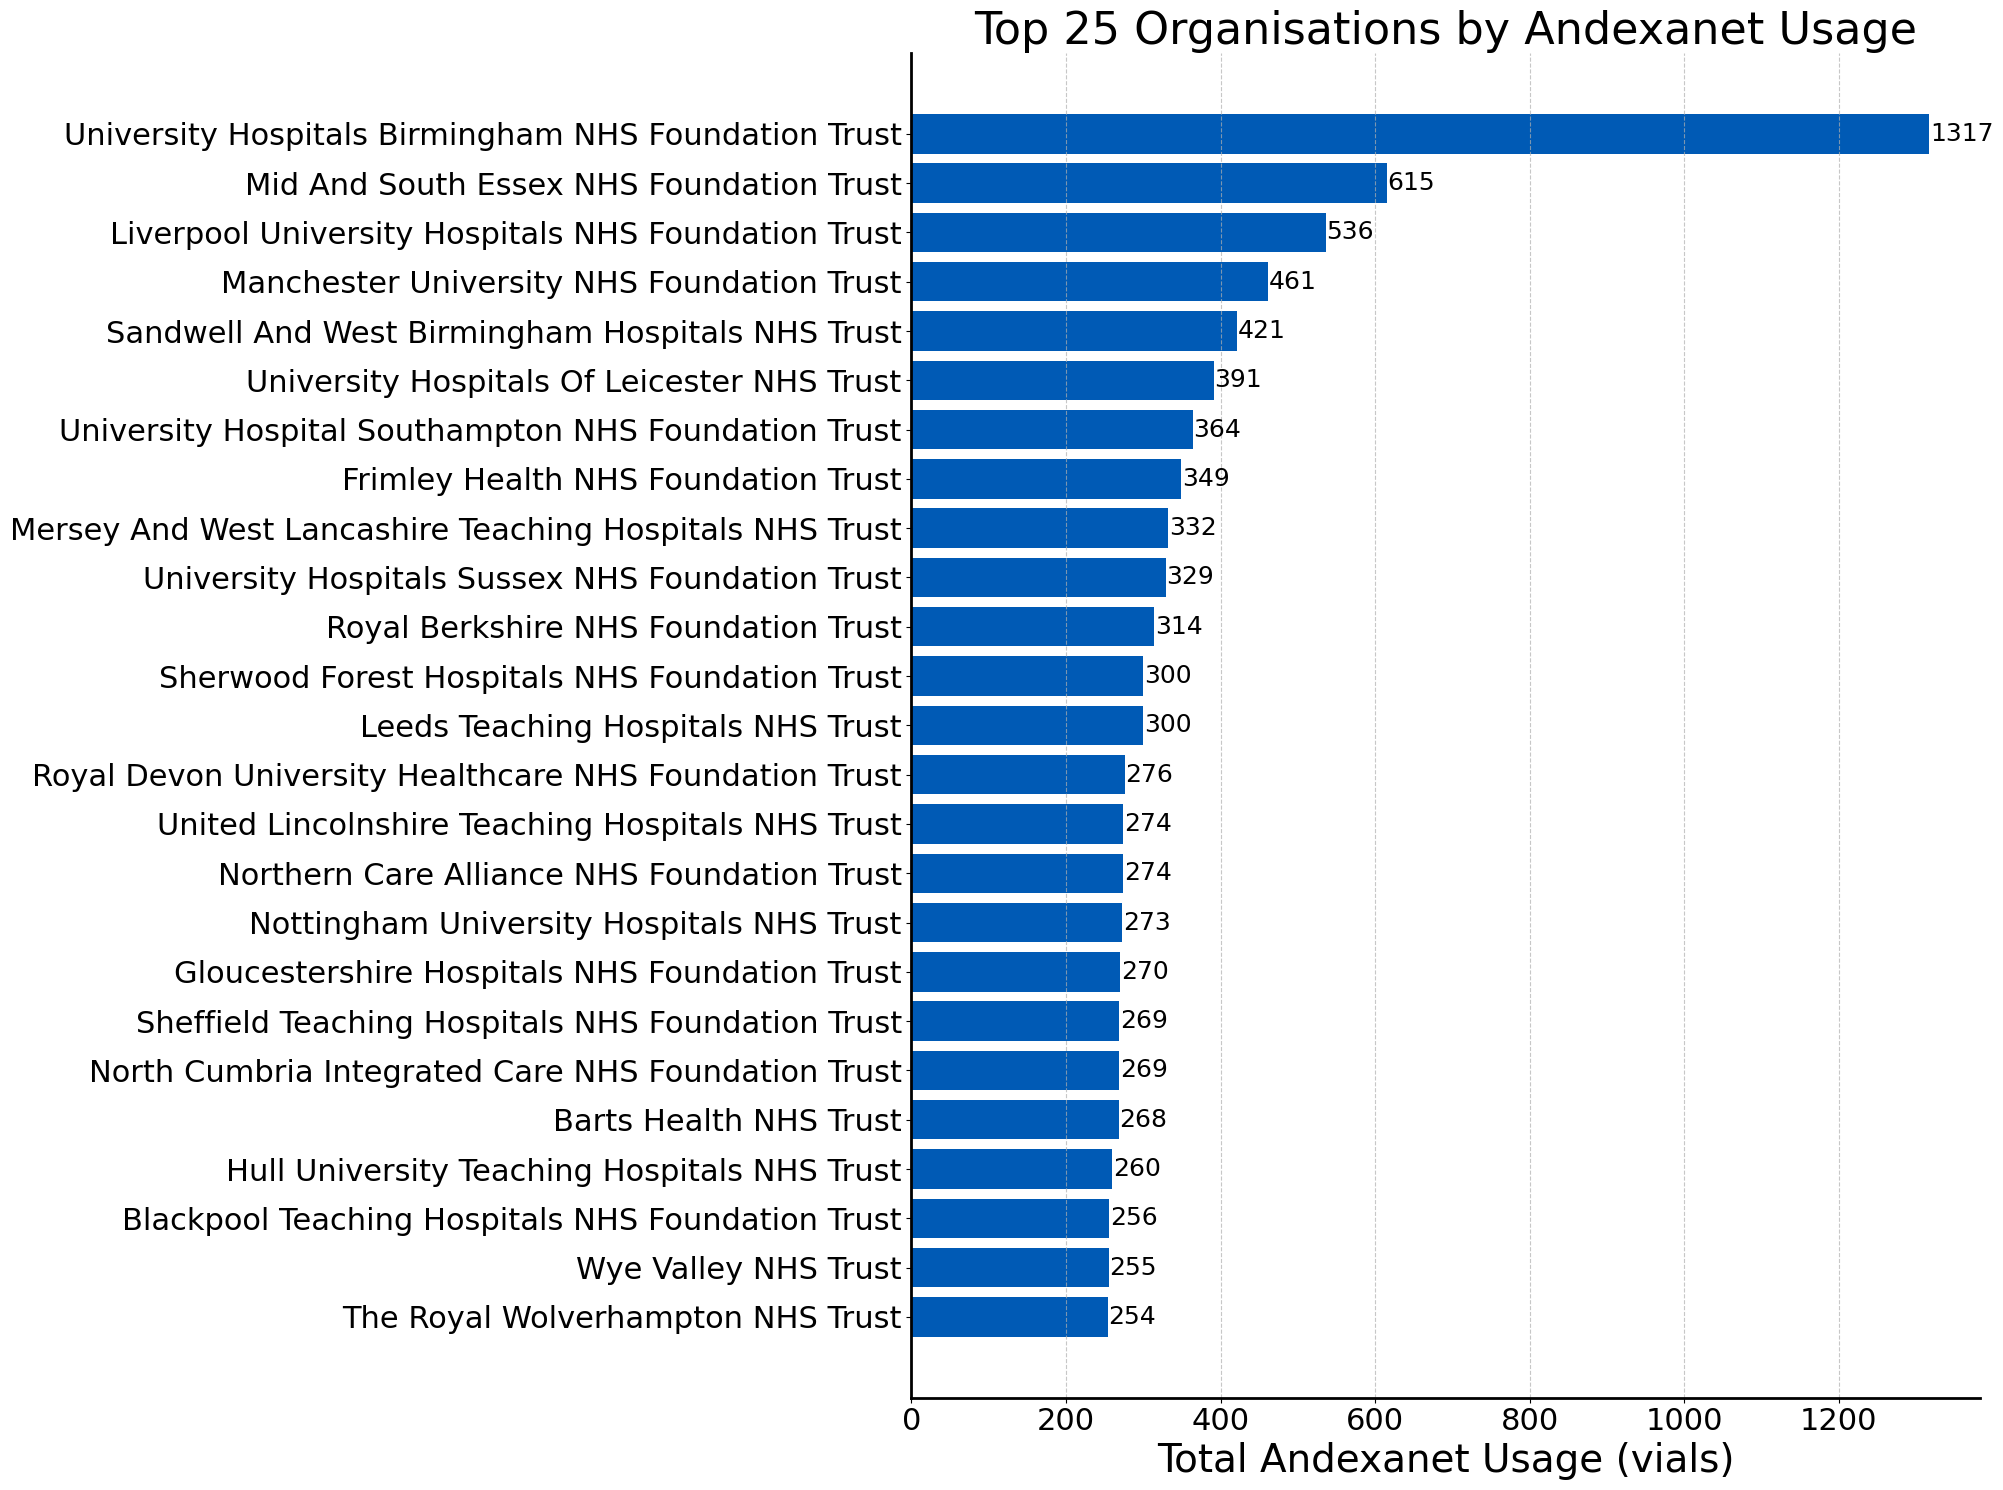

In [36]:
def plot_top_25_orgs_by_usage(data, output_file_name):
    # Group by organization and sum the dose quantity
    org_usage = data.groupby('Trust Name')['Value'].sum().sort_values(ascending=False)
    
    # Get the top 50 organizations
    top_25_orgs = org_usage.head(25)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 15))
    
    # Plot horizontal bars
    bars = ax.barh(top_25_orgs.index[::-1], top_25_orgs.values[::-1], color='#005AB5')
    
    # Customize the plot
    ax.set_xlabel('Total Andexanet Usage (vials)', fontsize=28)
    ax.set_title('Top 25 Organisations by Andexanet Usage', fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=22)
    
    # Add value labels to the end of each bar
    for i, v in enumerate(top_25_orgs.values[::-1]):
        ax.text(v + 1, i, str(int(v)), va='center', fontsize=18)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    # Add grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR, output_file_name), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Call the function
plot_top_25_orgs_by_usage(andexanet_df, "top_25_orgs_by_andexanet_usage.png")